In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
    os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}



In [4]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

subjects = np.loadtxt(os.path.join(HCP_DIR,'subjects_list.txt'),dtype='str')

In [5]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.
  
      Args:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment 
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

      Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

      Args:
        subject (str): subject ID to load
        experiment (str) : Name of experiment
        run (int): 0 or 1

      Returns
        evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:    
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

    return frames_list

## Visualization

In [6]:
# # Visualization Different Task comparison inside a single ROI
my_exp  = 'WM'

cond = [1, 2, 3, 4]
LABELS = ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools"]



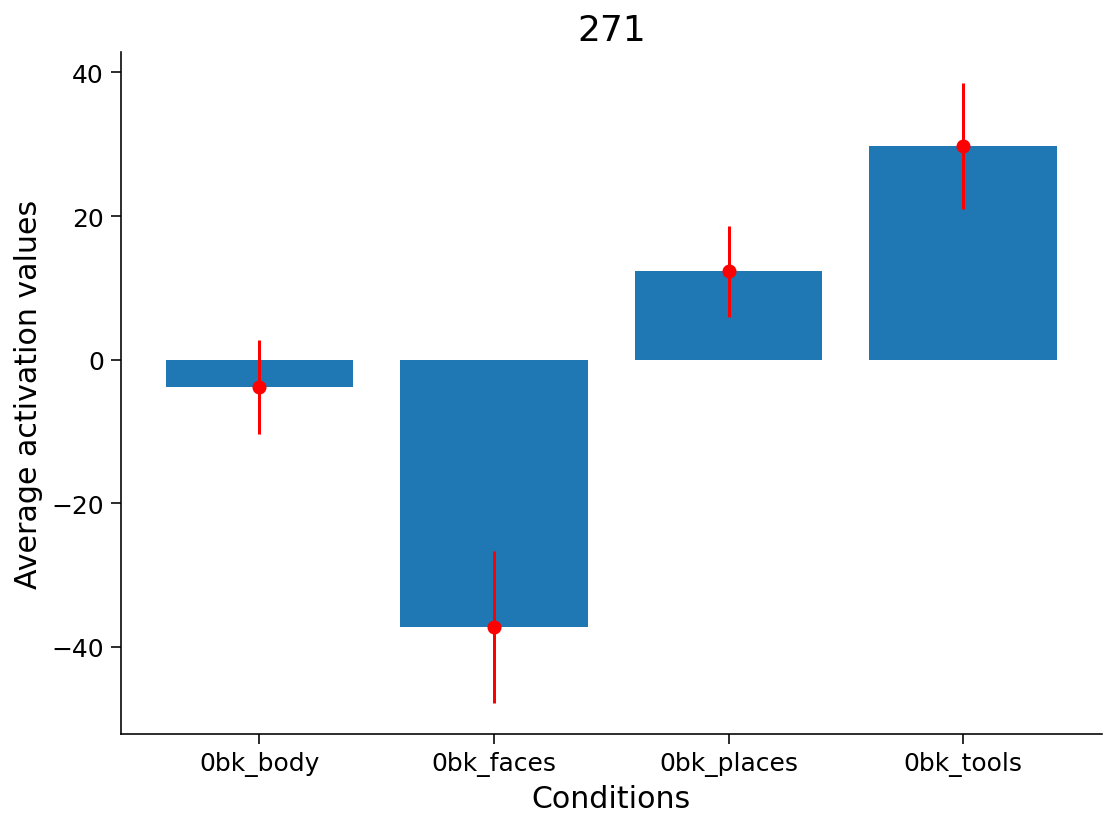

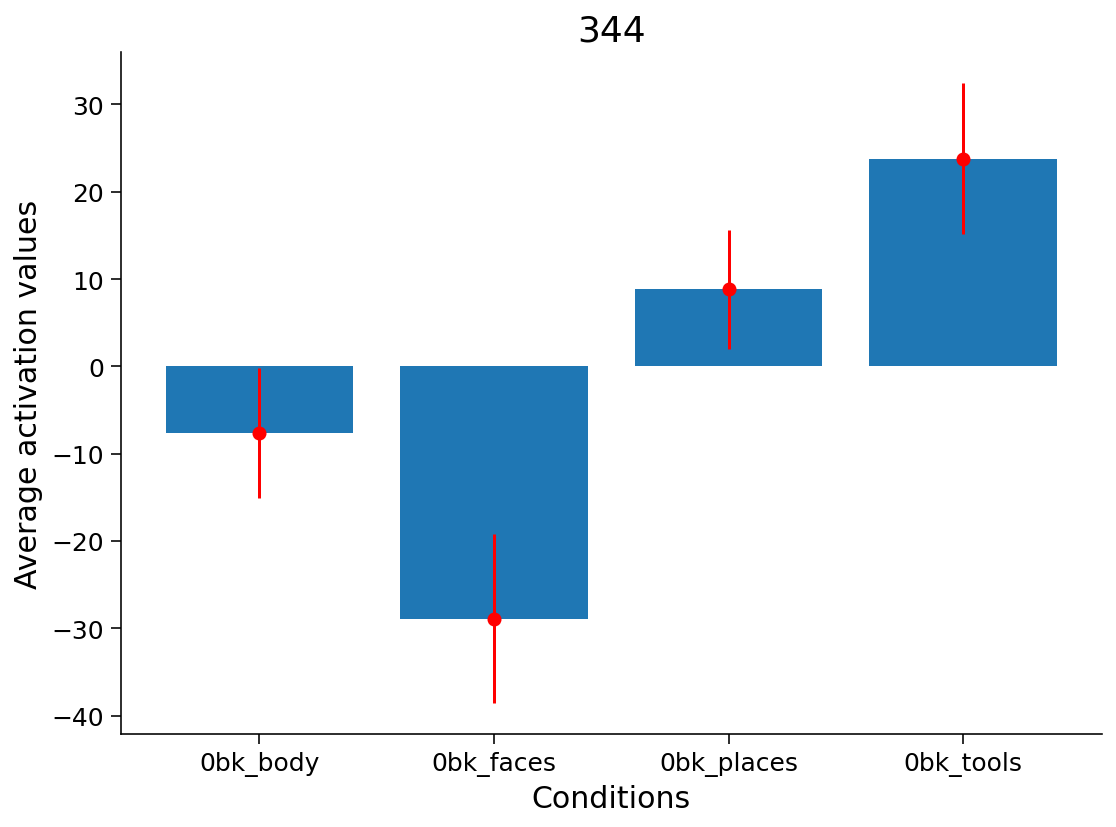

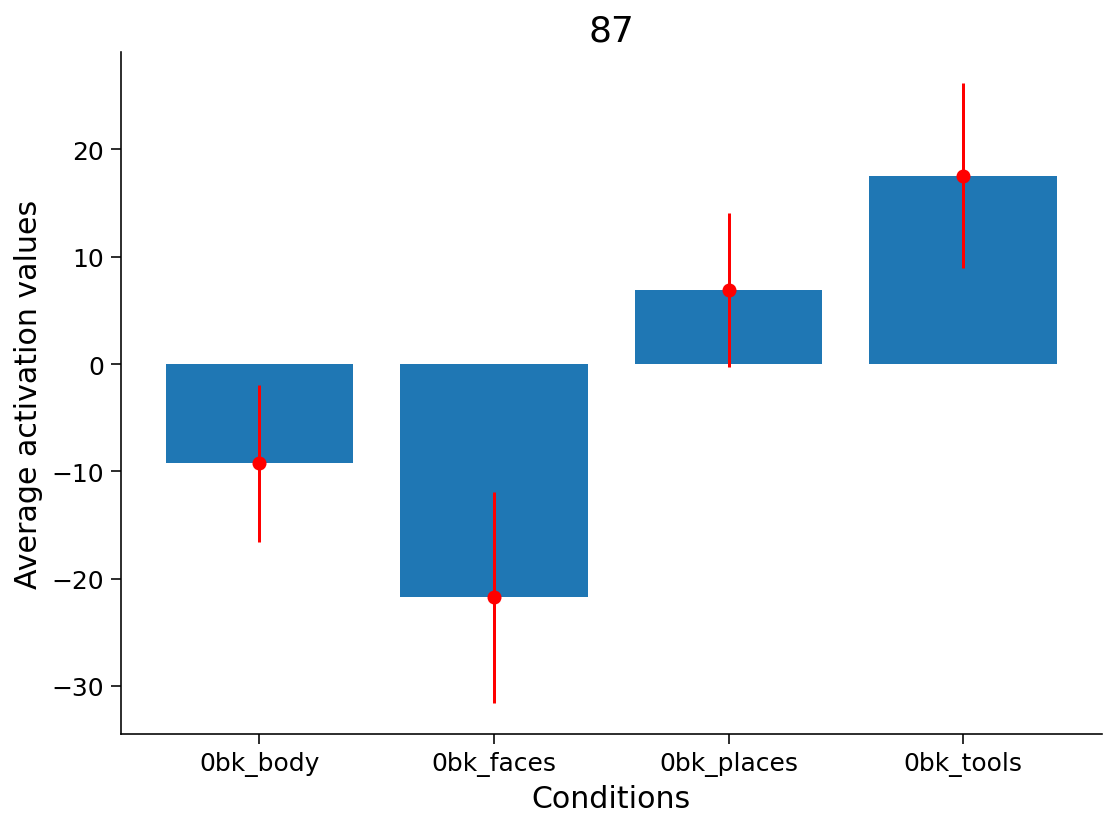

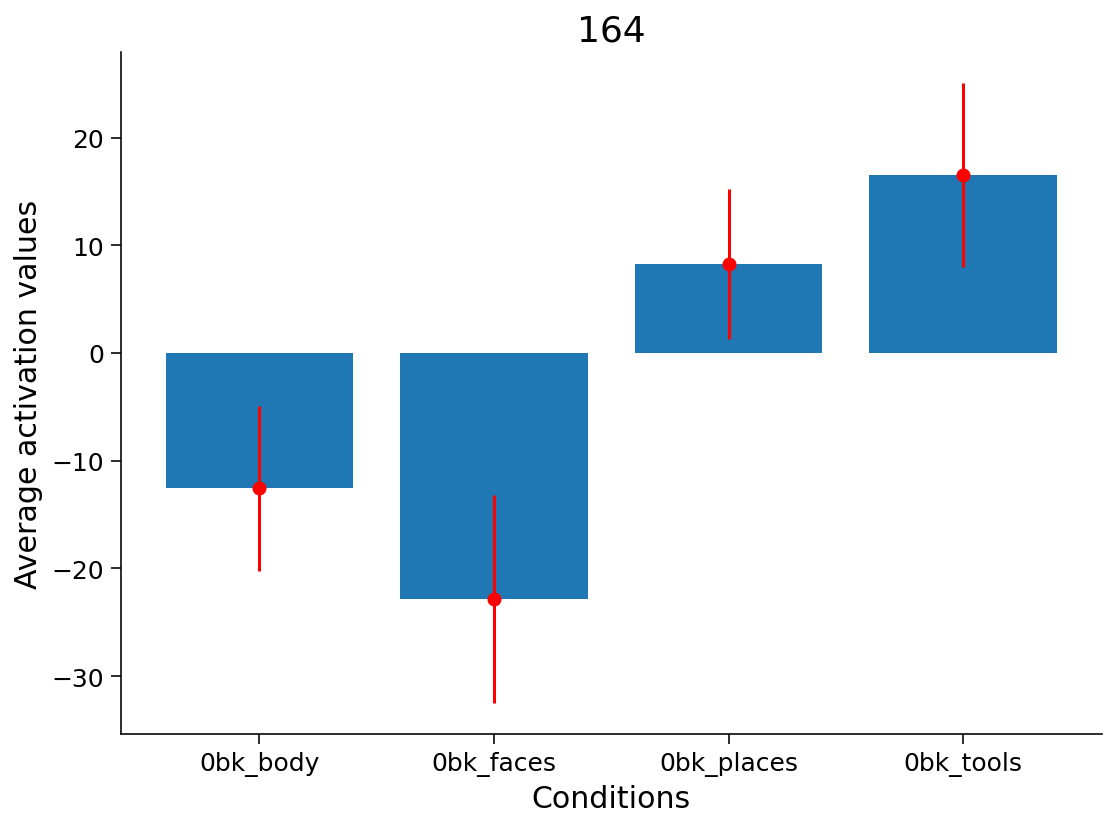

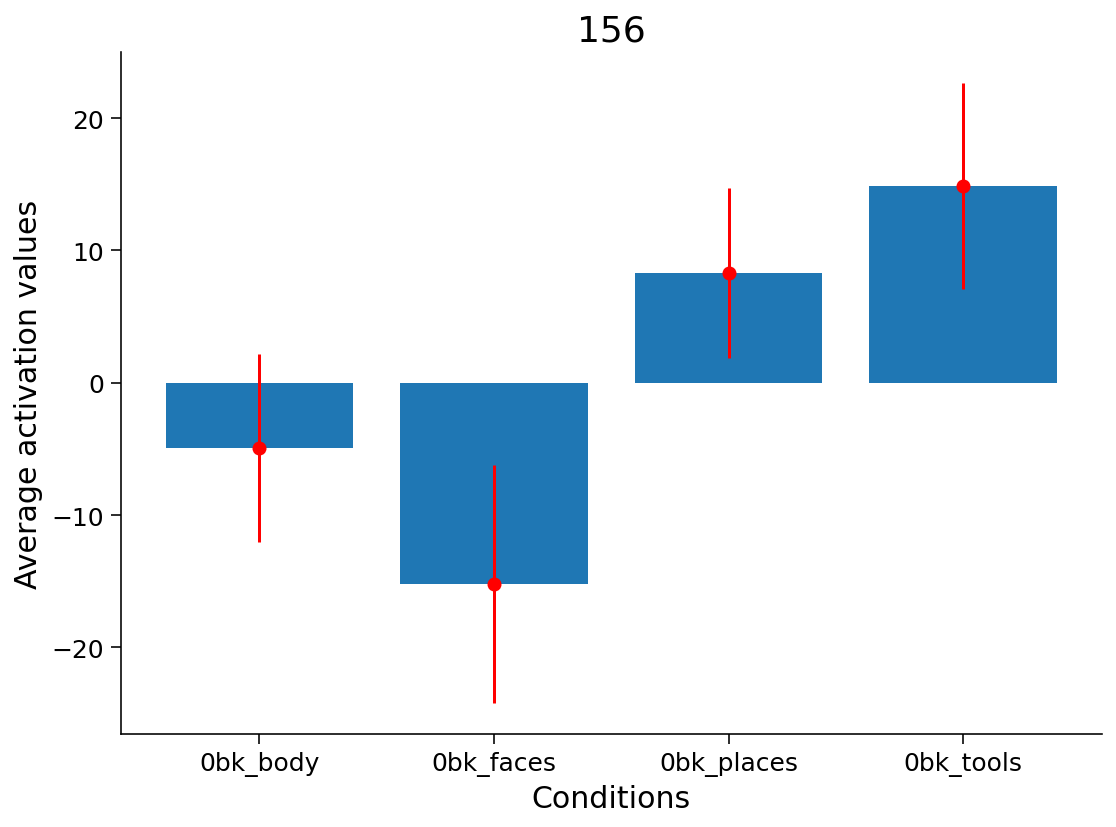

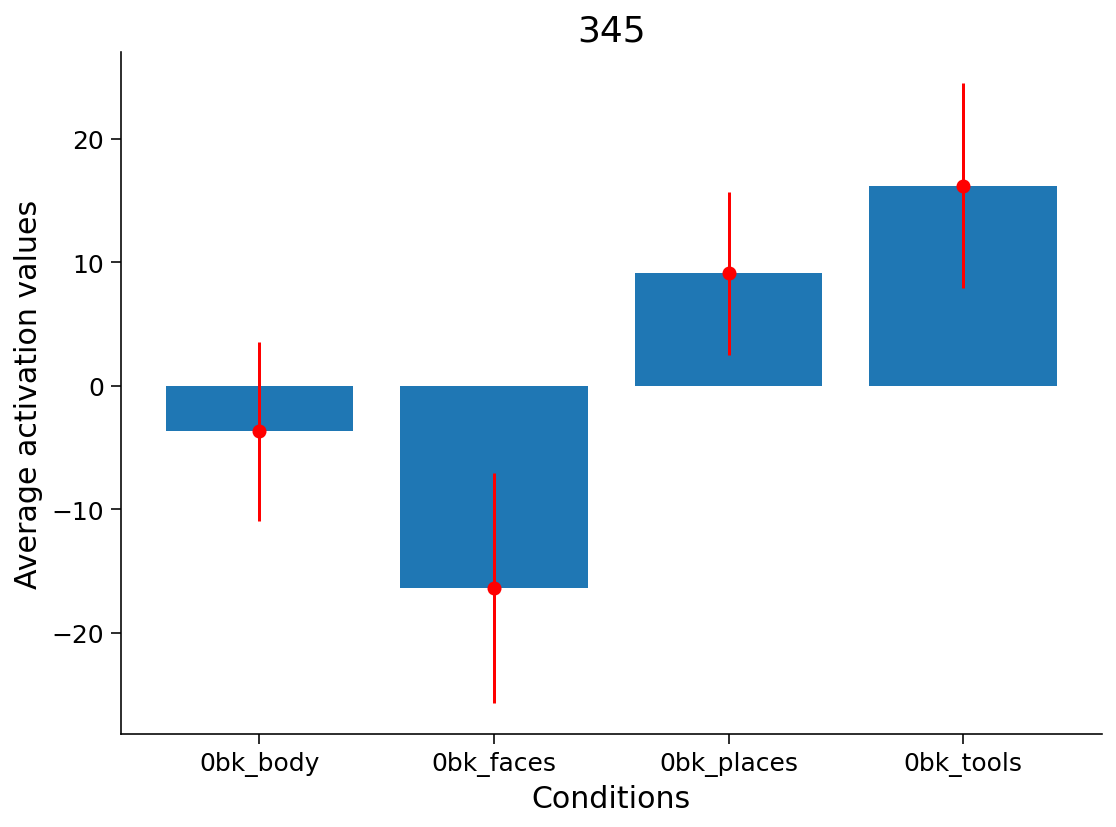

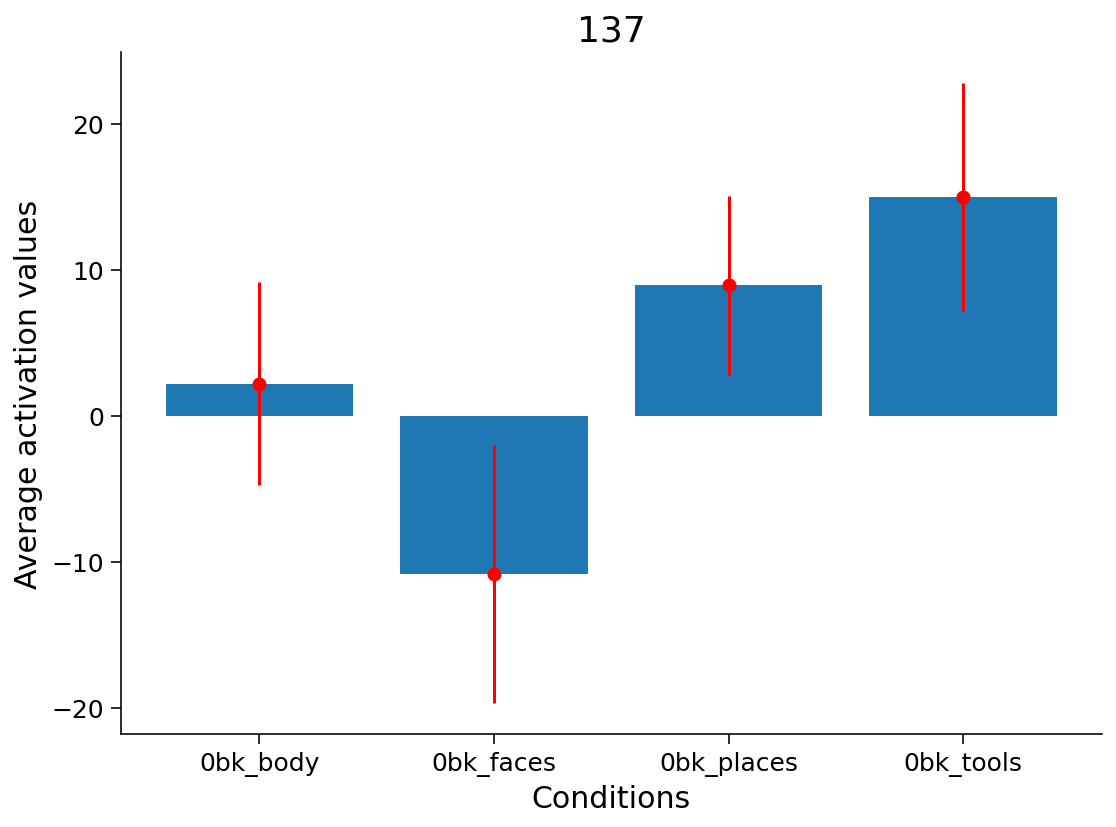

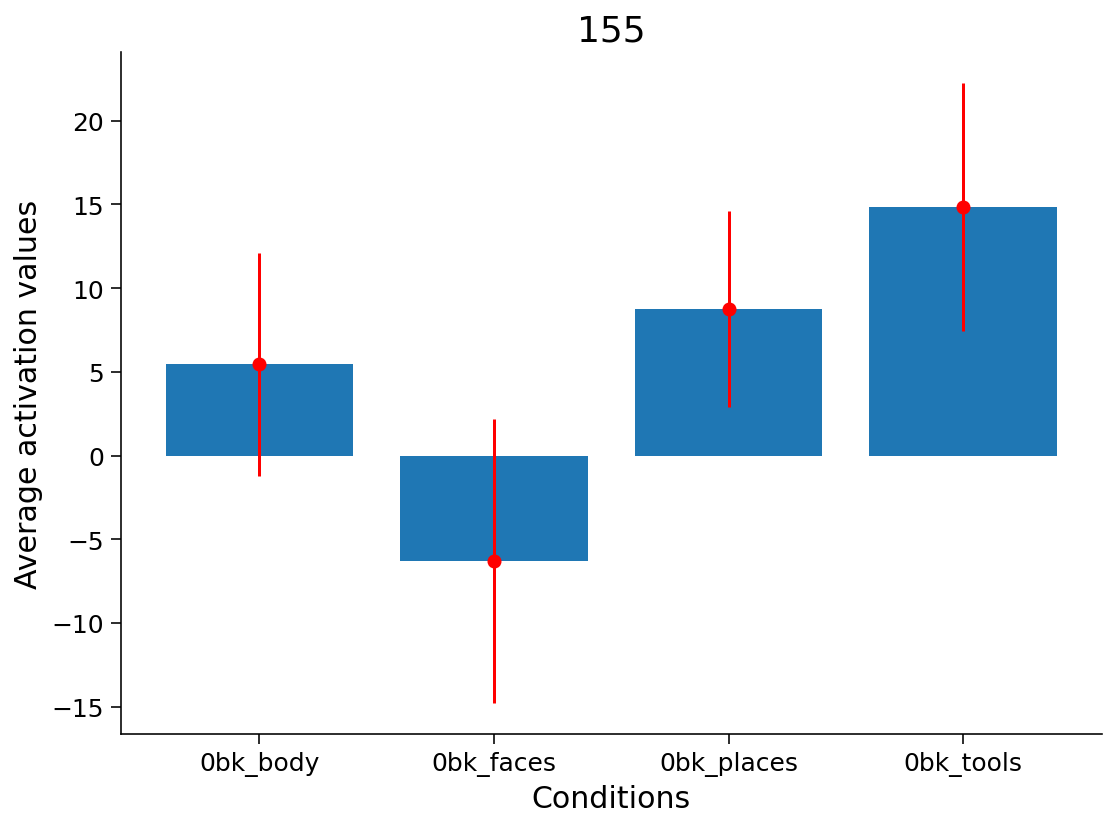

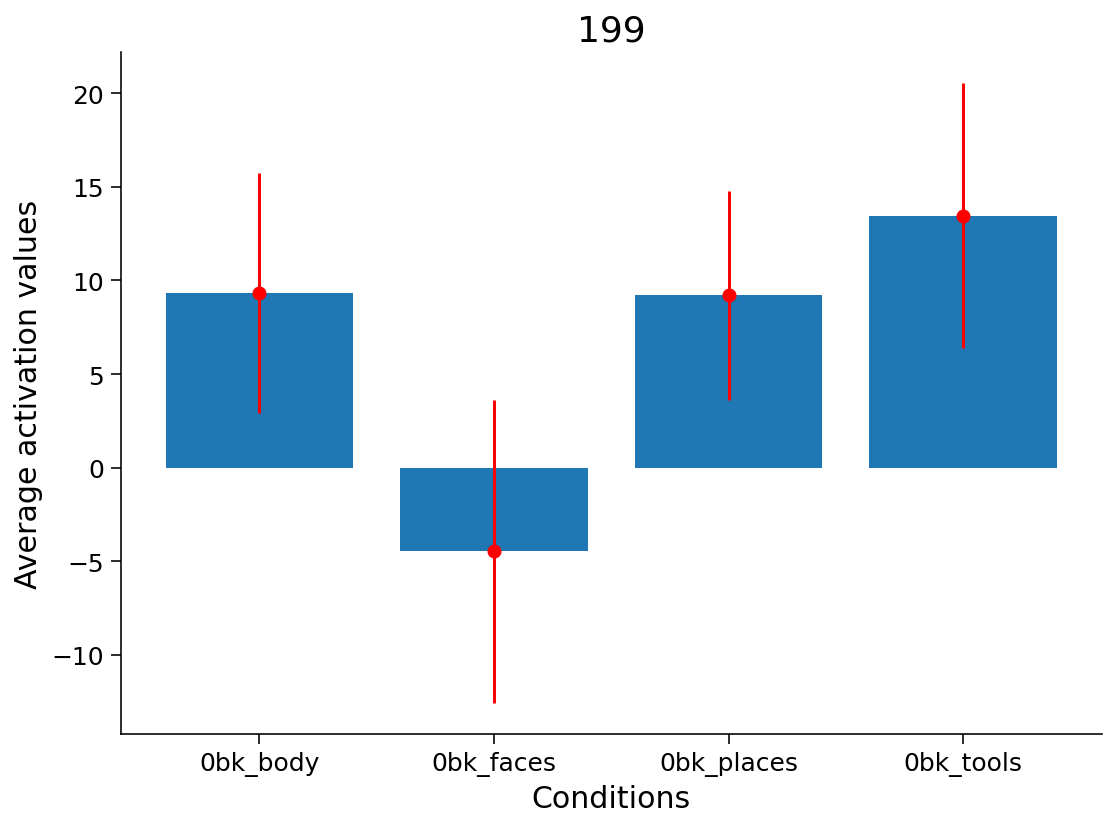

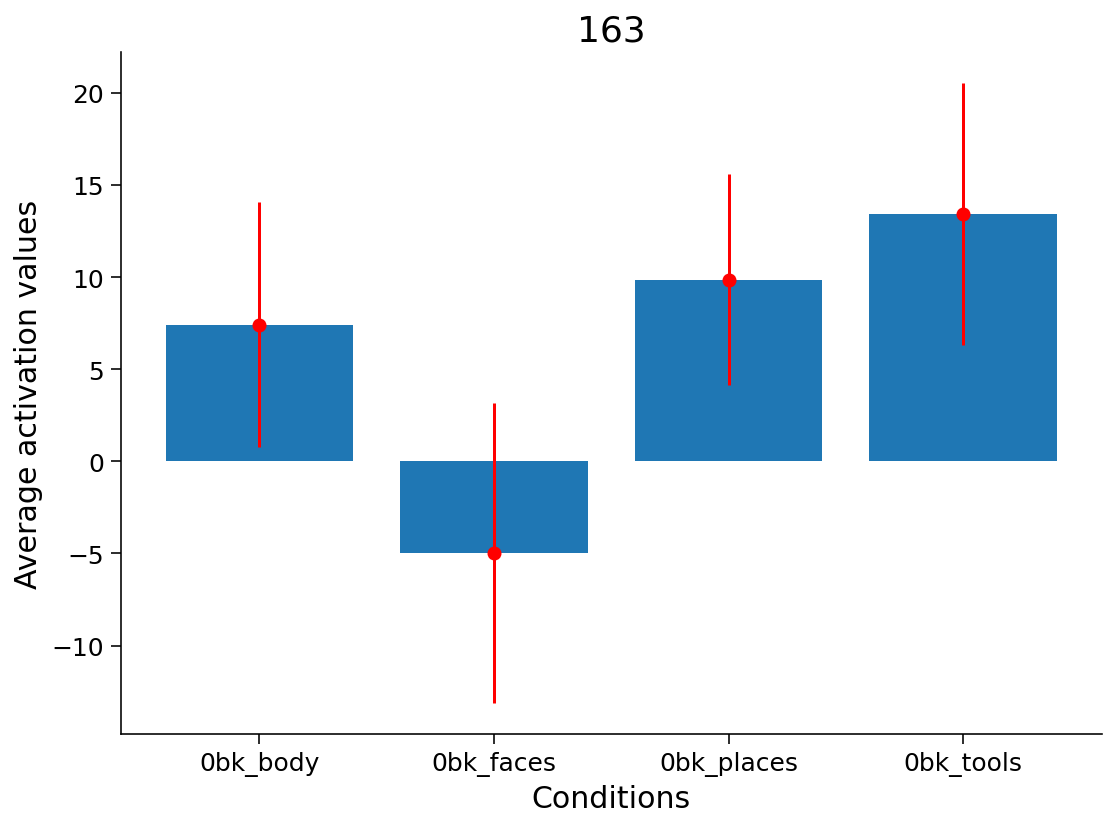

In [7]:
living_vs_nonLiving = [271, 344, 345, 159, 87, 339, 153, 1641, 64, 163]
four_cond = [271, 344, 87, 164, 345, 163, 137, 155, 335, 199]
face_vs_rest = [271, 344, 87, 164, 156, 345, 137, 155, 199, 163]

trial_all_subj = []
trial_all_subj_bodies = []
trial_all_subj_faces = []
trial_all_subj_places = []
trial_all_subj_tools = []

for rois in face_vs_rest:
    for my_subj in subjects:
        #for i in range(0, 2):
        for r in [0, 1]:
            data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=r,remove_mean=True)
        
            trial_all_subj_bodies.append(np.mean(data[rois][152:191]))
            trial_all_subj_faces.append(np.mean(data[rois][53:92]))
            trial_all_subj_places.append(np.mean(data[rois][212:251]))
            trial_all_subj_tools.append(np.mean(data[rois][311:350]))
        
    trial_all_subj = [np.mean(trial_all_subj_bodies)] + [np.mean(trial_all_subj_faces)] + [np.mean(trial_all_subj_places)] + [np.mean(trial_all_subj_tools)]
    trial_all_sub_var =[np.std(trial_all_subj_bodies)] + [np.std(trial_all_subj_faces)] + [np.std(trial_all_subj_places)] + [np.std(trial_all_subj_tools)]
    trial_all_sub_SME =[np.std(trial_all_subj_bodies)/np.sqrt(len(subjects))] + [np.std(trial_all_subj_faces)/np.sqrt(len(subjects))] + [np.std(trial_all_subj_places)/np.sqrt(len(subjects))] + [np.std(trial_all_subj_tools)/np.sqrt(len(subjects))]
    
    plt.bar(cond, trial_all_subj)
    plt.errorbar(cond, trial_all_subj, yerr=trial_all_sub_SME, fmt="o", color="r")
    plt.xticks(cond, LABELS)
    #plt.title('ROI ', rois , 'conditions for all subjects')
    plt.title(rois)
    plt.xlabel('Conditions')
    plt.ylabel('Average activation values')
    plt.show()

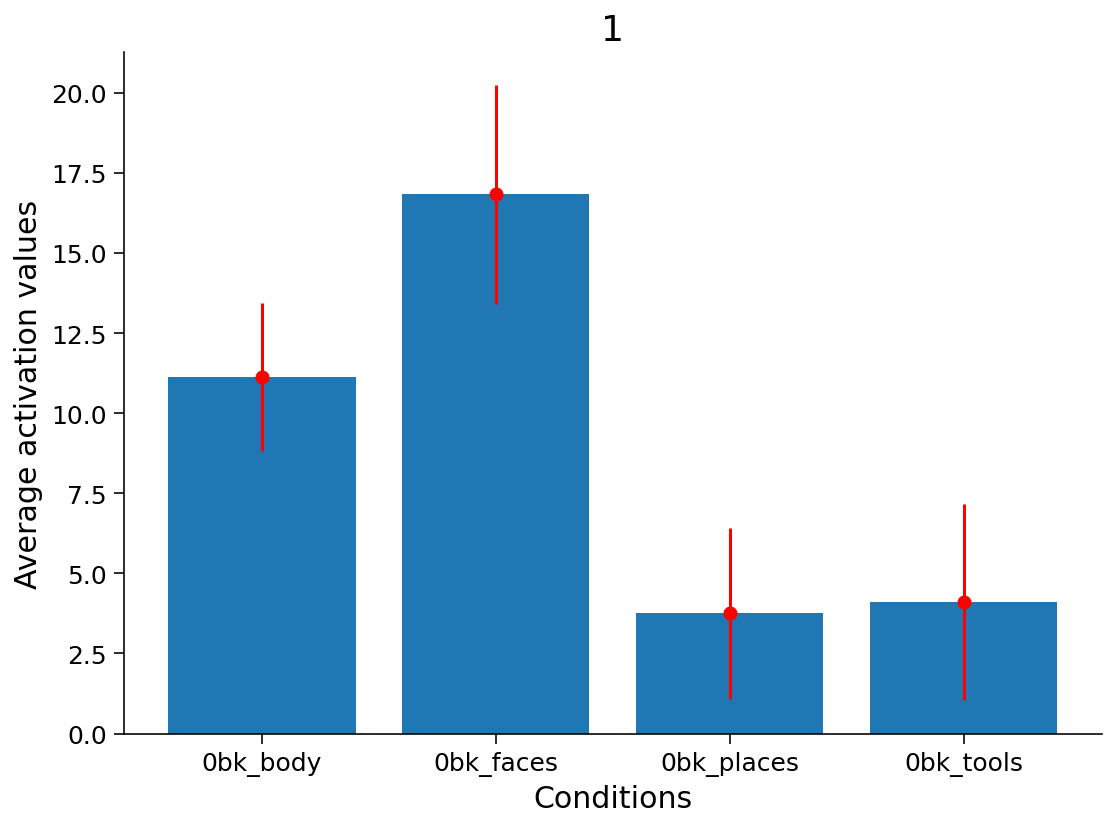

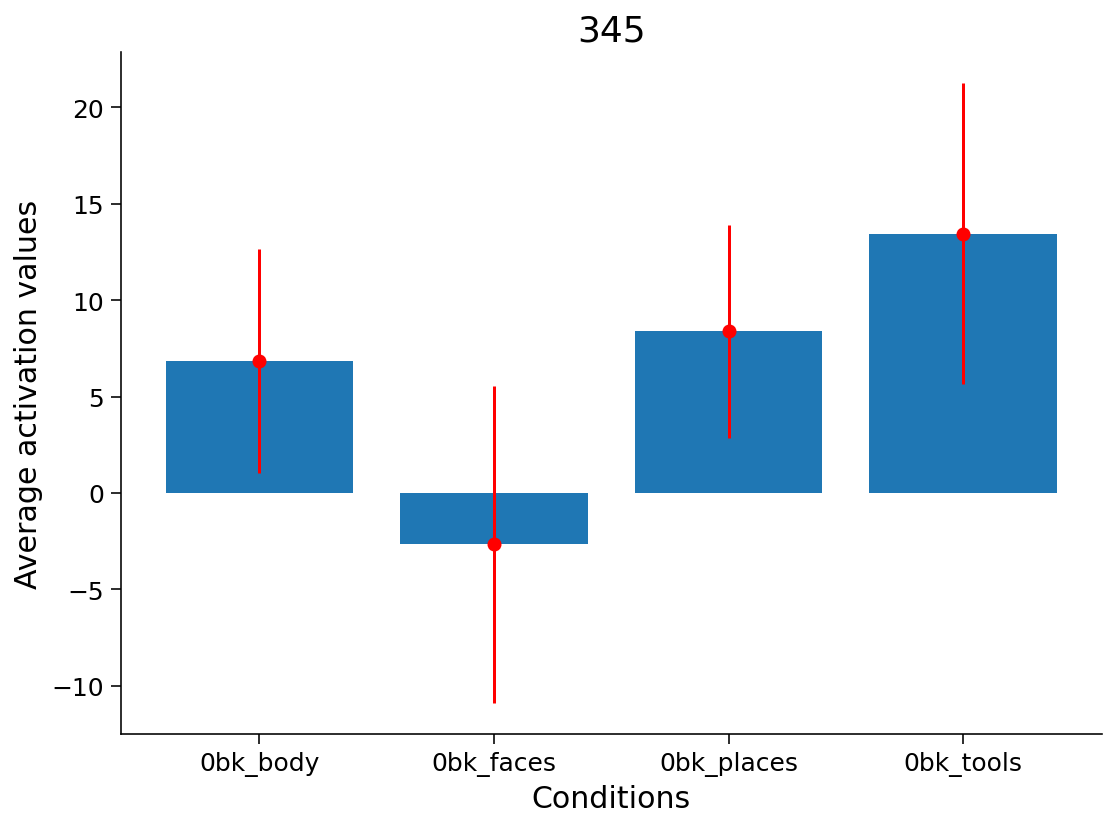

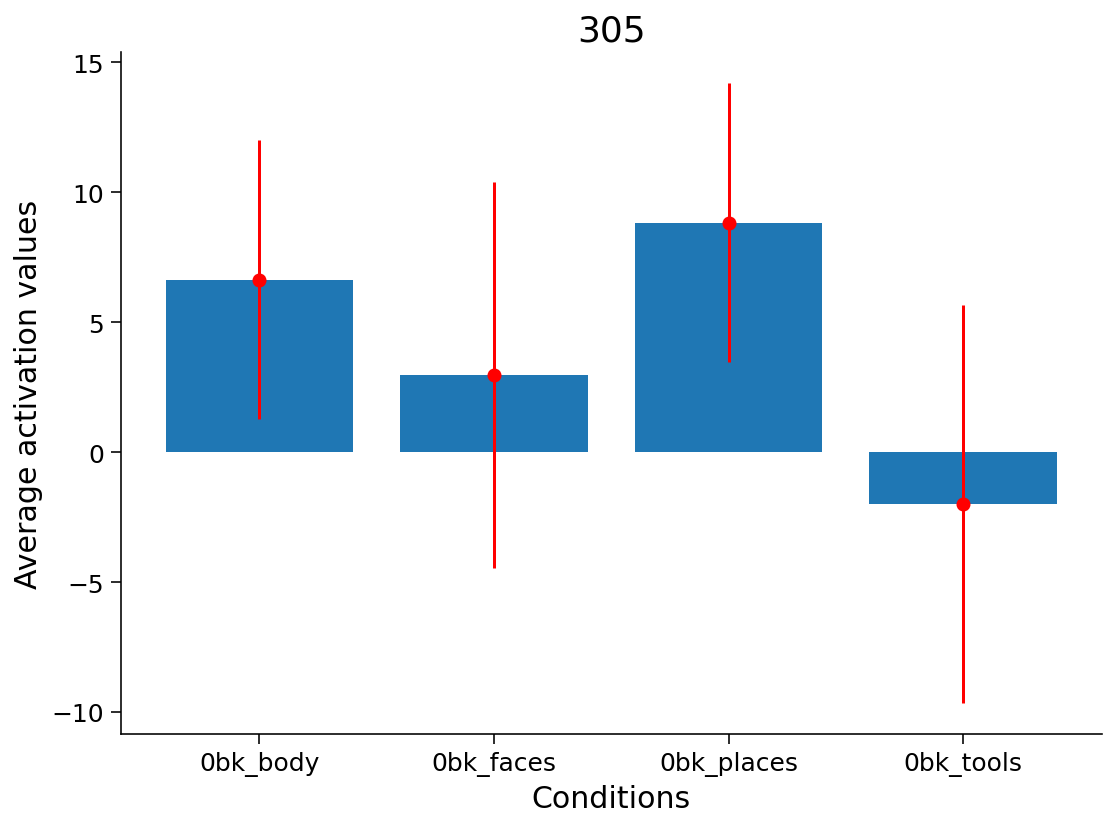

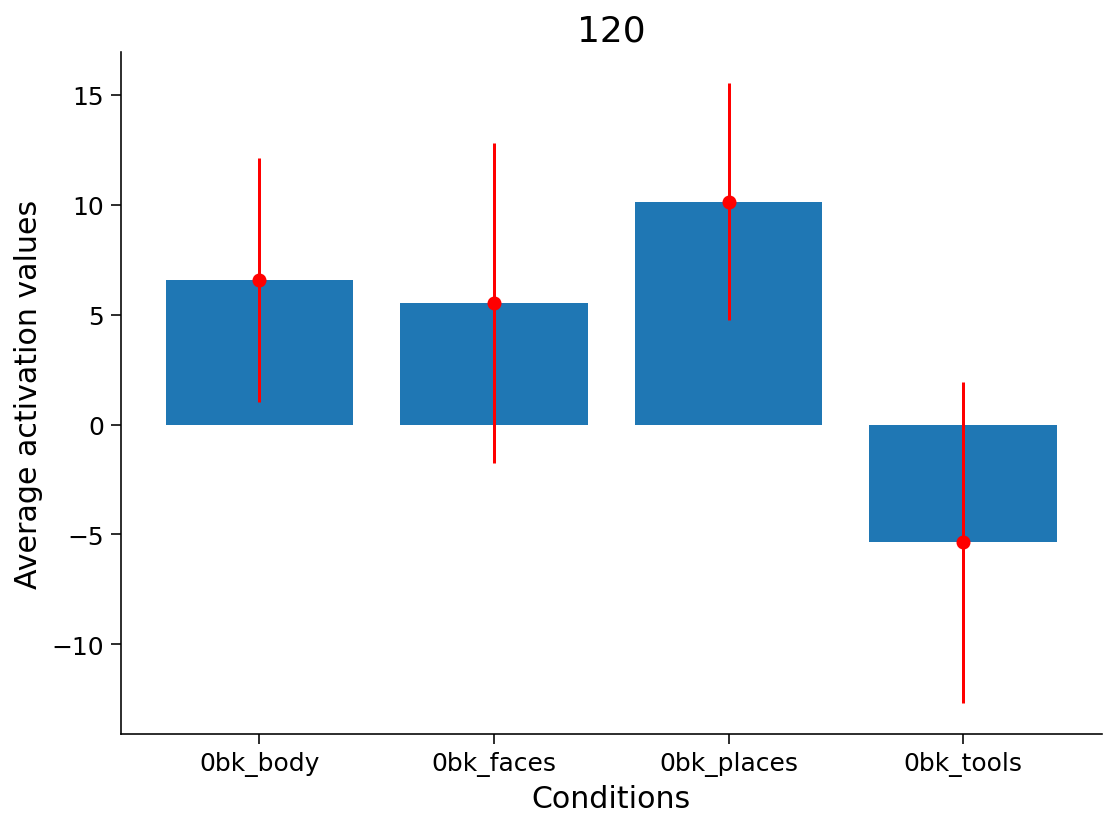

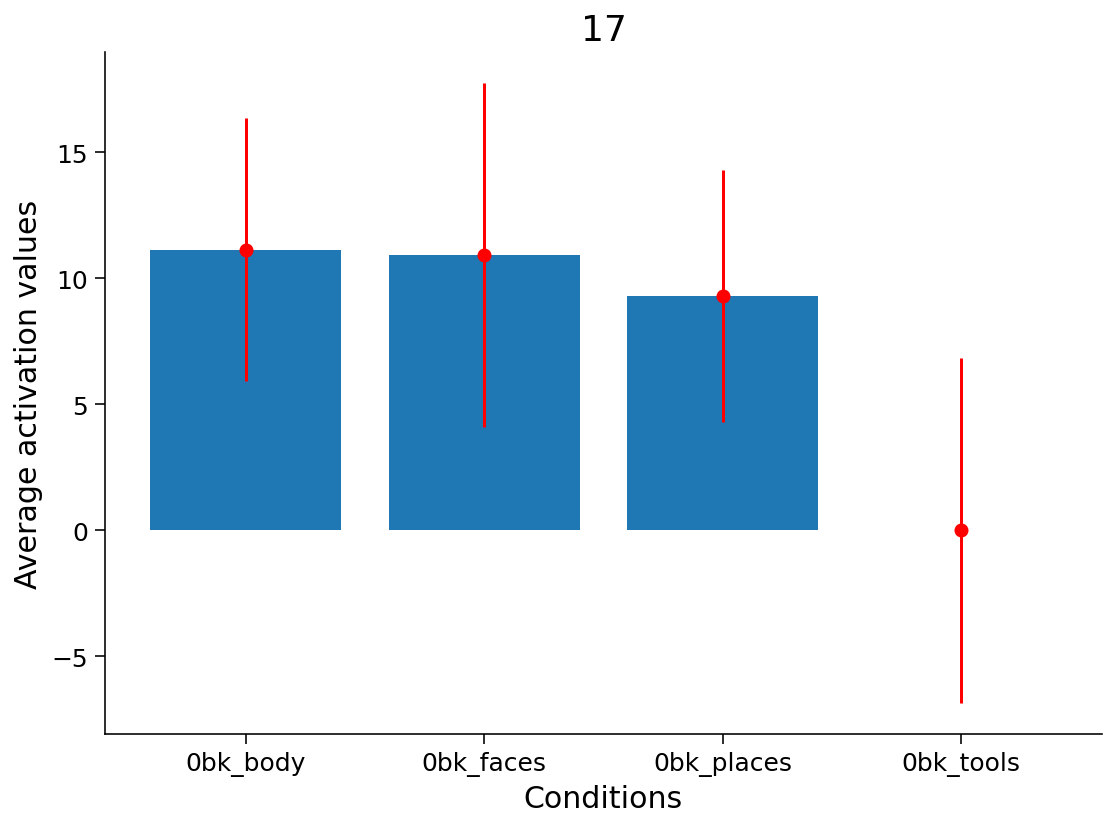

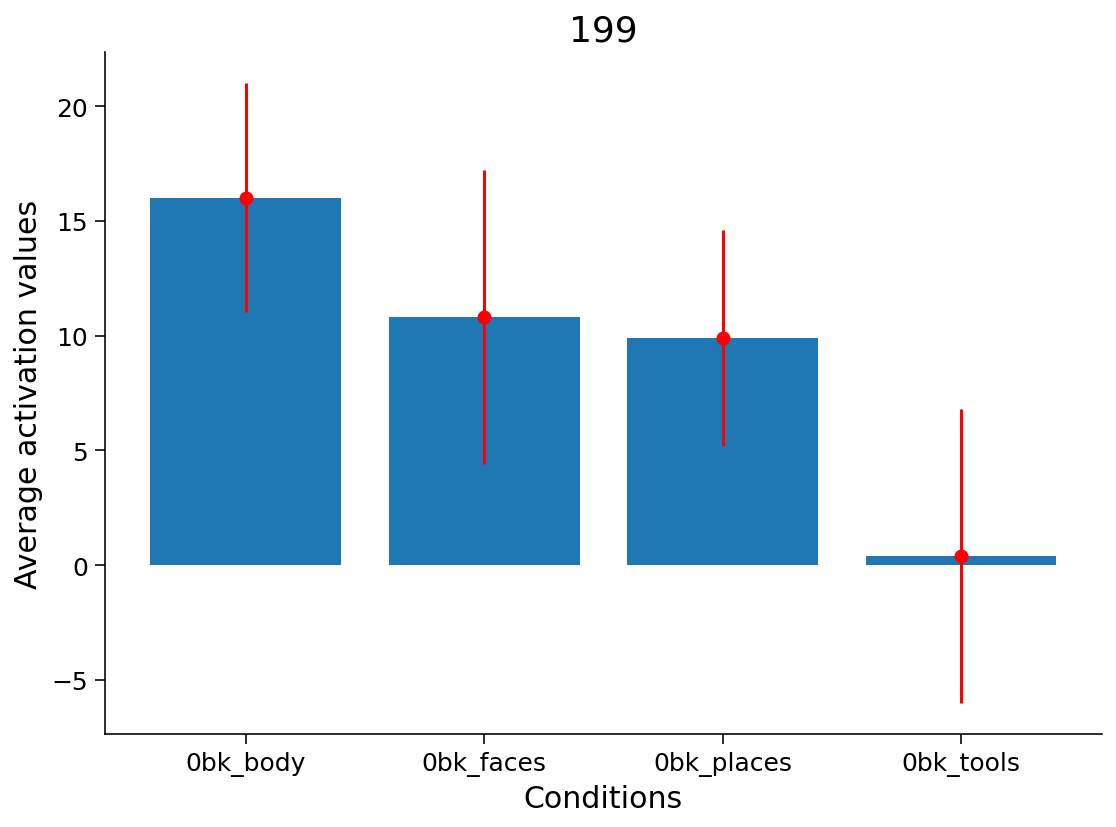

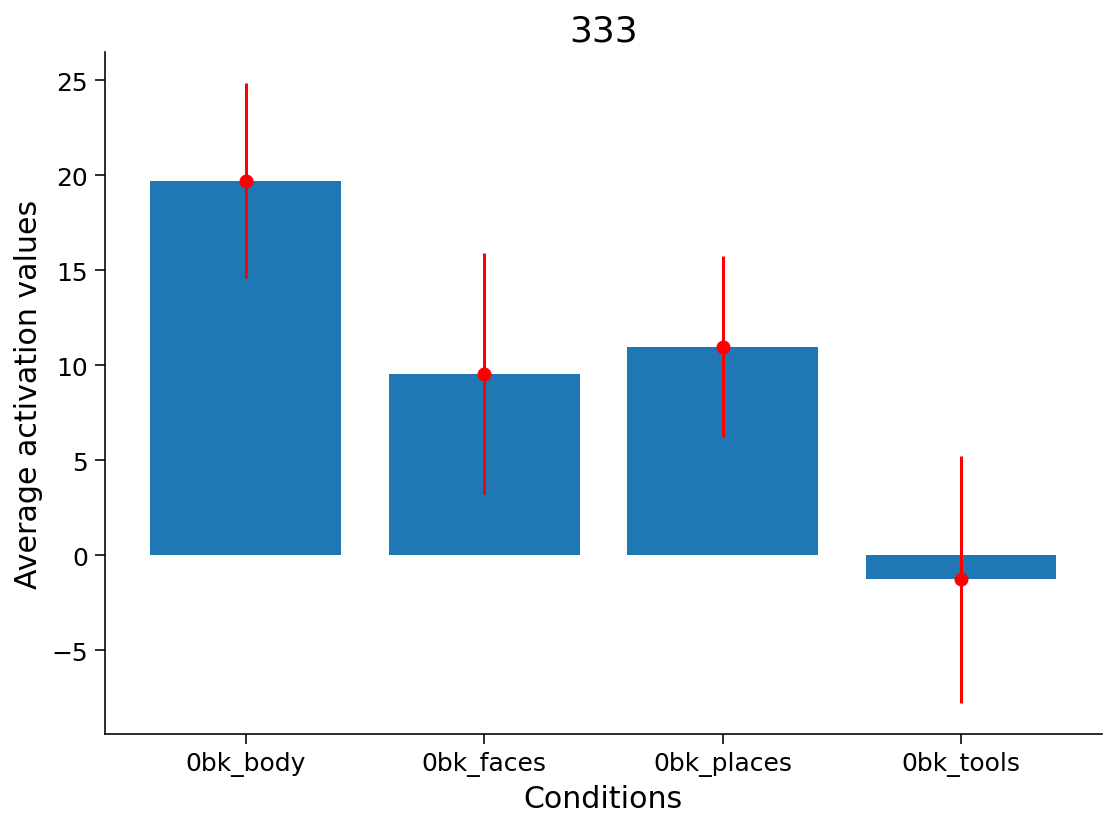

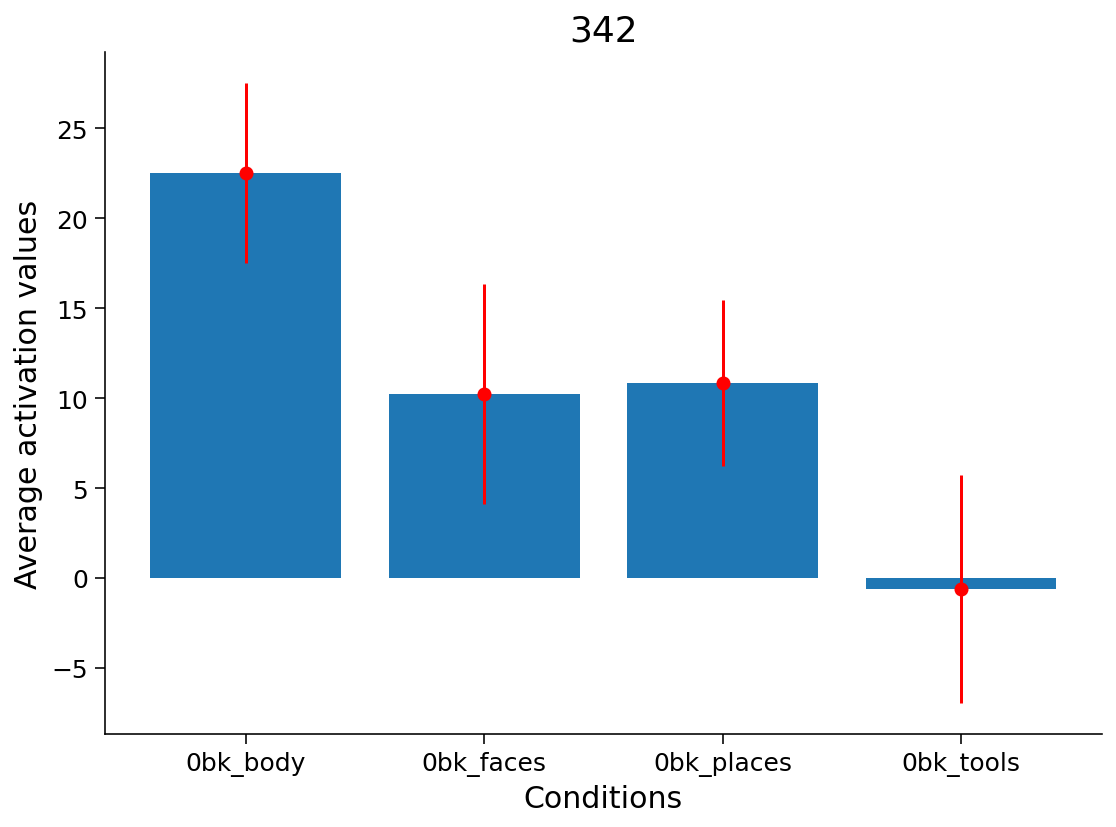

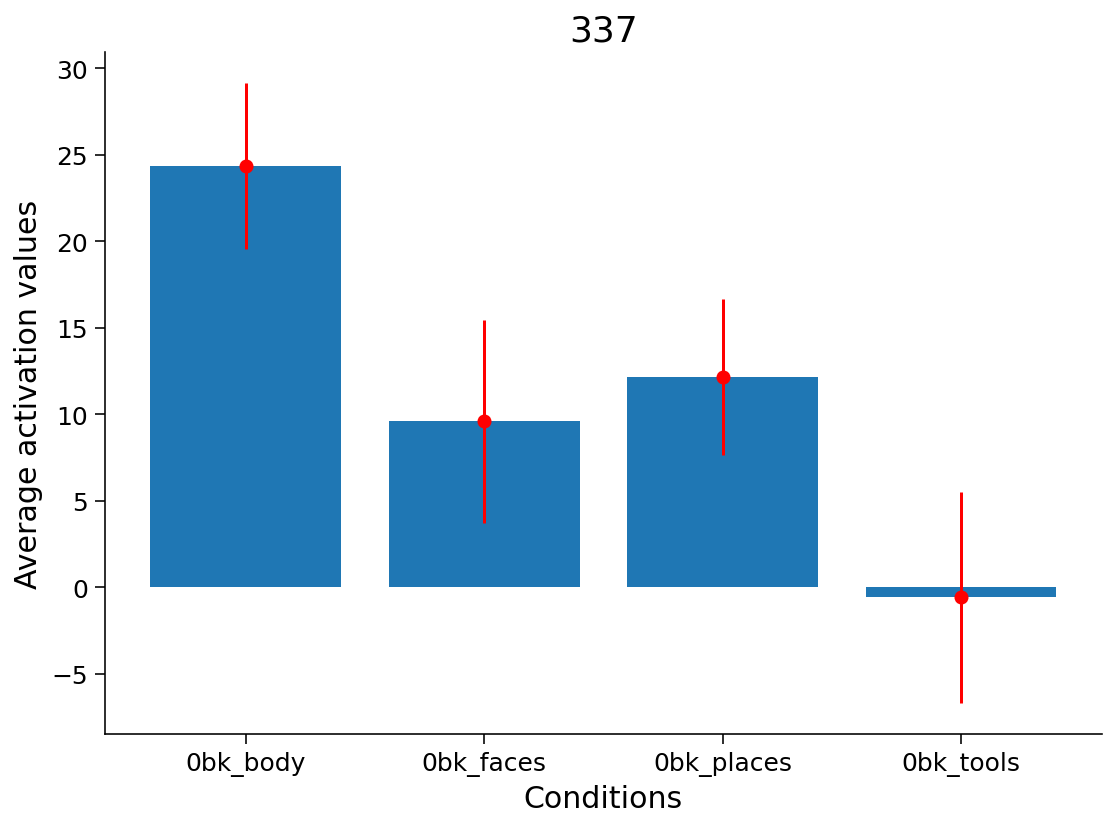

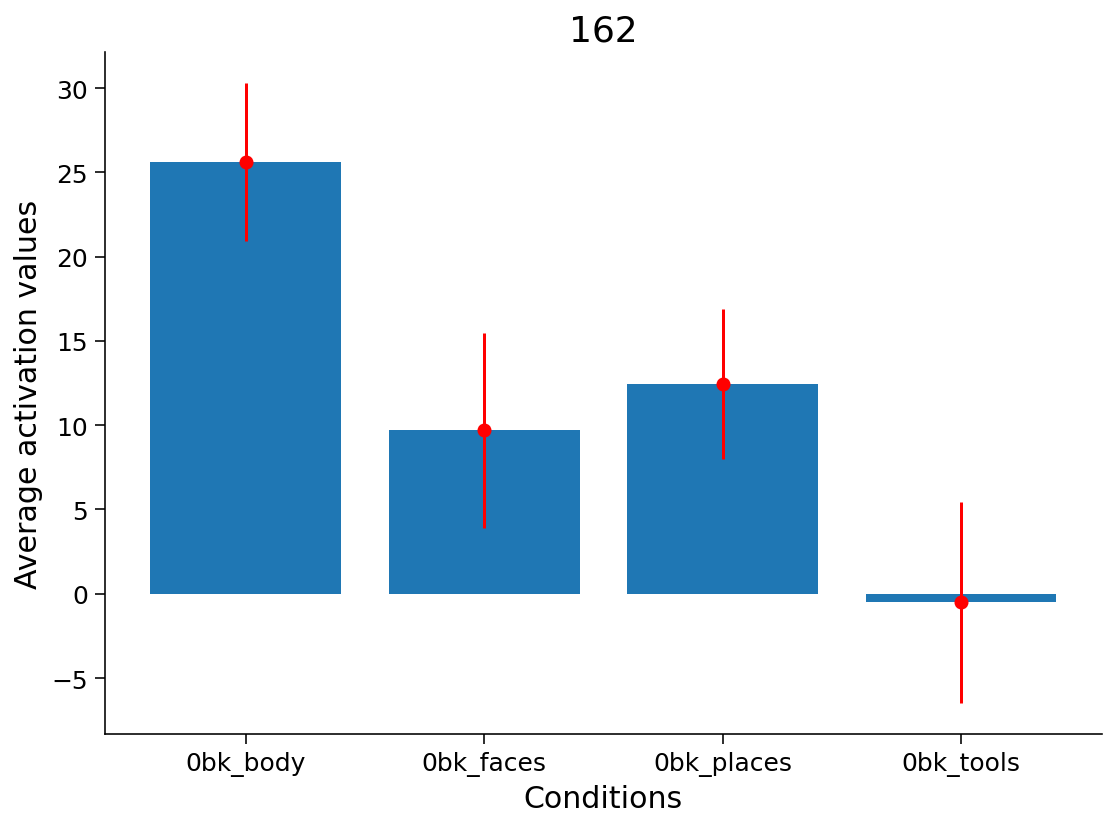

In [8]:
living_vs_nonLiving = [271, 164, 87, 165, 267, 338, 132, 312, 172, 333]
four_cond = [199, 333, 342, 337, 162, 1, 345, 305, 122, 140]
face_vs_rest = [1, 345, 305, 120, 17, 199, 333, 342, 337, 162]

trial_all_subj = []
trial_all_subj_bodies = []
trial_all_subj_faces = []
trial_all_subj_places = []
trial_all_subj_tools = []

for rois in face_vs_rest:
    for my_subj in subjects:
        #for i in range(0, 2):
        for r in [0, 1]:
            data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=r,remove_mean=True)
        
            trial_all_subj_bodies.append(np.mean(data[rois][152:191]))
            trial_all_subj_faces.append(np.mean(data[rois][53:92]))
            trial_all_subj_places.append(np.mean(data[rois][212:251]))
            trial_all_subj_tools.append(np.mean(data[rois][311:350]))
        
    trial_all_subj = [np.mean(trial_all_subj_bodies)] + [np.mean(trial_all_subj_faces)] + [np.mean(trial_all_subj_places)] + [np.mean(trial_all_subj_tools)]
    trial_all_sub_var =[np.std(trial_all_subj_bodies)] + [np.std(trial_all_subj_faces)] + [np.std(trial_all_subj_places)] + [np.std(trial_all_subj_tools)]
    trial_all_sub_SME =[np.std(trial_all_subj_bodies)/np.sqrt(len(subjects))] + [np.std(trial_all_subj_faces)/np.sqrt(len(subjects))] + [np.std(trial_all_subj_places)/np.sqrt(len(subjects))] + [np.std(trial_all_subj_tools)/np.sqrt(len(subjects))]
    
    plt.bar(cond, trial_all_subj)
    plt.errorbar(cond, trial_all_subj, yerr=trial_all_sub_SME, fmt="o", color="r")
    plt.xticks(cond, LABELS)
    #plt.title('ROI ', rois , 'conditions for all subjects')
    plt.title(rois)
    plt.xlabel('Conditions')
    plt.ylabel('Average activation values')
    plt.show()